In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [37]:
# One node on Gadi has 48 cores - try and use up a full core before going to multiple nodes (jobs)

walltime = '00:30:00'
cores = 2
memory = '8GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),
                                '-l mem='+str(memory),
                                '-P xv83',
                                '-l storage=gdata/xv83+gdata/rt52+scratch/xv83'],
                     header_skip=["select"])

In [38]:
cluster.scale(jobs=1)
client = Client(cluster)

In [39]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.64.69:8787/status,
Dashboard: http://10.6.64.69:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.64.69:35899,Workers: 0
Dashboard: http://10.6.64.69:8787/status,Total threads: 0
Started: 1 minute ago,Total memory: 0 B


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import xarray as xr
import numpy as np
import pandas as pd
import regionmask
import copy
import geopandas
from xbootstrap import block_bootstrap

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/xv83/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/xv83/dr6273/work/data/cartopy-data'

import functions as fn

In [7]:
plt_params = fn.get_plot_params()

In [8]:
# default colours
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load coffee data

In [9]:
# Order abbrevs and names by species and production
country_order = fn.get_country_order()

In [10]:
growing_calendar = pd.read_csv('/g/data/xv83/dr6273/work/projects/coffee/data/coffee_country_growing_calendar_extended.csv',
                               index_col=0)
growing_calendar.head()

,FAO,species,Proportion,Phase,Start,Finish,region,abbrevs
0,Brazil South,Arabica,0.601785,Flowering,8,11,178,BRS
1,Brazil South,Arabica,0.601785,Growing,12,4,178,BRS
4,Colombia,Arabica,1.000000,Flowering,2,4,32,CO
5,Colombia,Arabica,1.000000,Flowering,7,9,32,CO
6,Colombia,Arabica,1.000000,Growing,5,9,32,CO


In [11]:
arabica_abbrevs = np.unique(growing_calendar.loc[(growing_calendar.species == 'Arabica'), 'abbrevs'])
robusta_abbrevs = np.unique(growing_calendar.loc[(growing_calendar.species == 'Robusta'), 'abbrevs'])

### Tonnes data for 2019 (USDA)

In [12]:
region_names = ['Brazil S',
                'Colombia',
                'Ethiopia',
                'Honduras',
                'Peru',
                'Guatemala',
                'Mexico',
                'Nicaragua',
                'Vietnam',
                'Brazil N',
                'Indonesia',
                'Uganda',
                'India']

tonnes = np.array([
    2892000,
    832200,
    435000,
    432000,
    264000,
    222000,
    216000,
    156000,
    1761000,
    996000,
    564000,
    240000,
    222000])
                
tonnes = pd.DataFrame(tonnes, index=region_names, columns=['tonnes'])
tonnes['species_percentage'] = np.full(len(tonnes), np.nan)

In [ ]:
arabica_sum = tonnes['tonnes'].values[:8].sum()
for i, t in enumerate(tonnes['tonnes'].values[:8]):
    pc = (t / arabica_sum) * 100
    tonnes['species_percentage'].iloc[i] = pc

In [ ]:
robusta_sum = tonnes['tonnes'].values[8:].sum()
for i, t in enumerate(tonnes['tonnes'].values[8:]):
    pc = (t / robusta_sum) * 100
    tonnes['species_percentage'].iloc[i+8] = pc

### Country shapefiles

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world['coffee_percentage'] = np.nan
world = world.set_index('name')
world = world[['geometry', 'coffee_percentage']]

In [ ]:
n_brazil_shp = fn.get_n_Brazil_boundary()['geometry']
s_brazil_shp = fn.get_se_Brazil_boundary()['geometry']

In [ ]:
world.loc['Brazil N'] = [n_brazil_shp.iloc[0], tonnes.loc['Brazil N']['species_percentage']]
world.loc['Brazil S'] = [s_brazil_shp.iloc[0], tonnes.loc['Brazil S']['species_percentage']]

In [ ]:
world = world.loc[tonnes.index]
world['coffee_percentage'] = tonnes.loc[world.index]['species_percentage']

### Climate mode regions

In [ ]:
mode_vertices = {r'Ni$\mathrm{\tilde{n}}$o3.4': [(-170, -5), (-170, 5), (-120, 5), (-120, -5)],
                 'IOD W': [(50, -10), (50, 10), (70, 10), (70, -10)],
                 'IOD E': [(90, -10), (90, 0), (110, 0), (110, -10)],
                 r'Atl Ni$\mathrm{\tilde{n}}$o': [(-20, -5), (-20, 5), (0, 5), (0, -5)],
                 'TNA': [(-55, 5), (-55, 25), (-15, 25), (-15, 5)],
                 'TSA': [(-30, -20), (-30, 0), (-10, 0), (-10, -20)]}

In [ ]:
text_locs = {}
text_locs[r'Ni$\mathrm{\tilde{n}}$o3.4'] = [-168, -3]
text_locs['IOD W'] = [52, -20]
text_locs['IOD E'] = [92, -20]
text_locs[r'Atl Ni$\mathrm{\tilde{n}}$o'] = [-18, -30]
text_locs['TNA'] = [-53, 7]
text_locs['TSA'] = [-28, -18]

In [ ]:
with plt.rc_context(plt_params):
    figsize=(6.9, 4.5)
    fig = plt.figure(figsize=figsize, dpi=150)
    gs = fig.add_gridspec(nrows=2, ncols=1, figure=fig,height_ratios=[2,3])
    
    ### ===================================
    ### Coffee regions map
    ### ===================================
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    
    ax.coastlines(lw=plt_params['lines.linewidth']/3)
    ax.set_extent([-179.99, 180, -40, 40])
    ax.add_feature(cartopy.feature.BORDERS, lw=plt_params['lines.linewidth']/1.5, edgecolor='white')
    ax.add_feature(cartopy.feature.BORDERS, lw=plt_params['lines.linewidth']/3)
    world.plot(ax=ax, column='coffee_percentage', vmin=0, vmax=60, legend=False)
        
    n_brazil_shp.boundary.plot(ax=ax, color='r', lw=plt_params['lines.linewidth']/4)
    ax.plot((26, 26), (8, -90), color='r', ls='-', lw=plt_params['lines.linewidth']/1.2)
    ax.plot((48, 48), (90, 0), color='r', ls='-', lw=plt_params['lines.linewidth']/1.2)
    ax.plot((26.5, 48), (8, 0), color='r', ls='-', lw=plt_params['lines.linewidth']/1.2)
    
    ax.text(0.1, 0.05, 'Arabica', transform=ax.transAxes)
    ax.text(0.7, 0.05, 'Robusta', transform=ax.transAxes)
    
    ax.text(0.01, 0.9, 'a', weight='bold', transform=ax.transAxes)
        
    ### Plot mode boxes and names
    for mode, (v1, v2, v3, v4) in zip(mode_vertices.keys(), mode_vertices.values()):
        for line in [[v1, v2], [v2, v3], [v3, v4], [v4, v1]]:
            ax.plot((line[0][0], line[1][0]),
                    (line[0][1], line[1][1]),
                    color='k',
                    ls='--',
                   lw=plt_params['lines.linewidth']/3)
        ax.text(text_locs[mode][0], text_locs[mode][1], mode, fontsize=plt_params['font.size'])
    # Draw lines from names to boxes
    ax.plot((60, 60), (-13, -10), color='k', lw=plt_params['lines.linewidth']/3)
    ax.plot((100, 100), (-13, -10), color='k', lw=plt_params['lines.linewidth']/3)
    ax.plot((-5, -5), (-22, -5), color='k', lw=plt_params['lines.linewidth']/3)
        
    # custom legend as legend_kwds in world.plot() is not working as expected
    axins = inset_axes(ax, width="3%", height="100%",
                       bbox_to_anchor=(-0.03, .01, .5, .99),
                       bbox_transform=ax.transAxes, loc='lower left', borderpad=0)
    cmap = matplotlib.cm.viridis
    norm = matplotlib.colors.Normalize(vmin=0, vmax=60)

    cb1 = matplotlib.colorbar.ColorbarBase(ax=axins, cmap=cmap, norm=norm,
                                           ticks=range(0, 61, 20),
                                           orientation='vertical')
    axins.yaxis.set_ticks_position('left')
    axins.yaxis.set_label_position('left')
    cb1.set_label('2019 yield of primary\ncoffee species [%]')
        
    ### ===================================
    ### Growing calendar
    ### ===================================
    ax = fig.add_subplot(gs[1])
    
    country_order_i = [0, 1, 2, 3, 5, 8, 4, 6, 7, -1, 9, 11, 12, 13, 10]
    country_index = np.arange(len(country_order_i))
    
    flowering_start = growing_calendar.loc[(growing_calendar.Phase == 'Flowering'), 'Start'].iloc[country_order_i]
    flowering_finish = growing_calendar.loc[(growing_calendar.Phase == 'Flowering'), 'Finish'].iloc[country_order_i]
    
    growing_start = growing_calendar.loc[(growing_calendar.Phase == 'Growing'), 'Start'].iloc[country_order_i]
    growing_finish = growing_calendar.loc[(growing_calendar.Phase == 'Growing'), 'Finish'].iloc[country_order_i]
    
    phase_info = np.array([flowering_start,
                           flowering_finish,
                           growing_start,
                           growing_finish]).transpose()
    # When phases cross years, ensure the index is for the next year
    for i in range(3):
        phase_diff = np.diff(phase_info)
        phase_info[:,1:][np.where(phase_diff < 0)] = phase_info[:,1:][np.where(phase_diff < 0)] + 12
        
    # Set Uganda back 12 months
    phase_info[-3,:] = phase_info[-3,:] - 12
        
    # lengths of flowering and growing phases
    phase_diff = np.diff(phase_info)
    flowering_length = phase_diff[:,0] + 1
    growing_length = phase_diff[:,-1] + 1
    
    month_index_min = np.min(phase_info)
    month_index_max = np.max(phase_info) + 1
    
    # ============== Plot
    cmap = plt.cm.viridis
    norm = matplotlib.colors.BoundaryNorm(np.arange(5), cmap.N)
    c_ = np.array([0.333, 0.666, 0.999])
        
    ax.barh(country_index,
            flowering_length,
            left=phase_info[:,0],
            color=cmap(c_[0]),
            label='Flowering')
    
    ax.barh(country_index,
            growing_length,
            left=phase_info[:,2],
            color=cmap(c_[1]),
            label='Growing')
    
    for i in [1, 13]:
        ax.axvline(np.where(np.arange(month_index_min, month_index_max+1) == i)[0],
                   c='k',
                   ls='--',
                   lw=plt_params['lines.linewidth']/1.5)
    
    ax.set_xlim(month_index_min-0.1, month_index_max+0.1)
    ax.set_xticks(range(month_index_min, month_index_max+1))
    months = np.tile(['Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], 3)
    ax.set_xticklabels(months[month_index_min : month_index_max+1], rotation=30)
    
    ax.set_ylim(-0.7, len(country_index)-0.3)
    ax.set_yticks(country_index)
    ax.set_yticklabels(country_order.values())
    ax.invert_yaxis()
    
    ### Right-hand labels
    ax2 = ax.twinx()
    ax2.set_ylim(-0.7, len(country_index)-0.3)
    ax2.set_yticks([0, 1.5, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.5, 14])
    yticklabels_right = np.flip(np.round(tonnes['species_percentage'], 1))
    yticklabels_right = [str(i) + '%' for i in yticklabels_right]
#     yticklabels_right = [np.flip(tonnes.index)[i] + ' ' + yticklabels_right[i] for i in range(len(yticklabels_right))]
    ax2.set_yticklabels(yticklabels_right)
    ax2.tick_params(right=False)
    
    ax3 = ax.twinx()
    ax3.set_ylim(-0.7, len(country_index)-0.3)
    ax3.set_yticks(country_index)
    ax3.set_yticklabels([])
    
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    
    ax.text(-0.14, 0.7, 'Arabica', transform=ax.transAxes, rotation=90, ha='center', va='center')
    ax.text(-0.14, 0.2, 'Robusta', transform=ax.transAxes, rotation=90, ha='center', va='center')
    ax.annotate('', xy=(-0.16, 0.402), xycoords='axes fraction', xytext=(1.08, 0.402), 
        arrowprops=dict(arrowstyle="-", ls=':', lw=plt_params['lines.linewidth']/2))
#     ax.annotate('', xy=(0.997, 0.4), xycoords='axes fraction', xytext=(1.18, 0.4), 
#         arrowprops=dict(arrowstyle="-", ls=':', lw=plt_params['lines.linewidth']/2))
    ax.annotate('', xy=(-0.125, 0.), xycoords='axes fraction', xytext=(-0.125, 1), 
        arrowprops=dict(arrowstyle="-", ls=':', lw=plt_params['lines.linewidth']/2))
    
    ax.legend(loc=(0.73, 1), ncol=2, frameon=False, fontsize=plt_params['font.size'])
    
    ax.text(0.005, 1.03, 'b', weight='bold', transform=ax.transAxes)
    
    plt.savefig('./figures/coffee_info.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Gridded climate data relevant for each phase of coffee (growing and flowering)

### VPD
- Absolute threshold of $\mathrm{VPD} > 0.82$ kPa. Only on non-detrended data. From Kath (in review).

In [13]:
vpd_flowering = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/era5_vpd_Flowering_upper_tail_0.82.zarr',
                                 consolidated=True)
vpd_growing = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/era5_vpd_Growing_upper_tail_0.82.zarr',
                                  consolidated=True)

### Tmin averages
- For Robusta:
    - Absolute threshold of $T_\mathrm{min} > 18.6^{\circ}$C in the growing season, and  $T_\mathrm{min} < 15.8^{\circ}$C in the flowering season. From Kath et al (2020).

In [28]:
mn2t_flowering = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/berkeley_tmin_Flowering_lower_tail_15.8.zarr',
                                 consolidated=True)
mn2t_growing = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/berkeley_tmin_Growing_upper_tail_18.6.zarr',
                                  consolidated=True)

### Tmax averages
- For Arabica:
    - Absolute threshold of $T_\mathrm{max} > 29.5^{\circ}$C in the growing season From Kath et al (in review).

In [29]:
mx2t_growing = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/berkeley_tmax_Growing_upper_tail_29.5.zarr',
                                  consolidated=True)

### Tmin/Tmax averages from Descroix and Snoeck (2004)

- Arabica 18-22 C
- Robusta 22-28 C

In [30]:
t2m_lt_growing_arabica_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/berkeley_temperature_Growing_lower_tail_18.zarr',
                                             consolidated=True)
t2m_lt_growing_robusta_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/berkeley_temperature_Growing_lower_tail_22.zarr',
                                             consolidated=True)

In [31]:
t2m_ut_growing_arabica_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/berkeley_temperature_Growing_upper_tail_22.zarr',
                                             consolidated=True)
t2m_ut_growing_robusta_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/berkeley_temperature_Growing_upper_tail_28.zarr',
                                             consolidated=True)

### D&S Precip ranges:

- Arabica: 1400 < P < 2000
- Robusta: 2000 < P < 2500

In [32]:
tp_lt_growing_arabica_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/gpcc_precip_Annual_lower_tail_1400.zarr',
                                             consolidated=True)
tp_lt_growing_robusta_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/gpcc_precip_Annual_lower_tail_2000.zarr',
                                             consolidated=True)

In [33]:
tp_ut_growing_arabica_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/gpcc_precip_Annual_upper_tail_2000.zarr',
                                             consolidated=True)
tp_ut_growing_robusta_optimal = xr.open_zarr('/g/data/xv83/dr6273/work/projects/coffee/data/gpcc_precip_Annual_upper_tail_2500.zarr',
                                             consolidated=True)

### Proportion of each country, and global coffee area, in drought each year

In [34]:
vpd_grid_template = 'era5'
temperature_grid_template = 'berkeley'
precip_grid_template = 'gpcc'

### VPD events

In [40]:
vpd_flowering_events = fn.calculate_event_statistics(vpd_flowering, vpd_grid_template).compute()

In [41]:
vpd_growing_events = fn.calculate_event_statistics(vpd_growing, vpd_grid_template).compute()

### Tmin averages events

In [42]:
mn2t_flowering_events = fn.calculate_event_statistics(mn2t_flowering, temperature_grid_template).compute()

In [43]:
mn2t_growing_events = fn.calculate_event_statistics(mn2t_growing, temperature_grid_template).compute()

### Tmax averages events

In [44]:
mx2t_growing_events = fn.calculate_event_statistics(mx2t_growing, temperature_grid_template).compute()

### T ranges events

In [45]:
# Select relevant countries for each species and concat
arabica_season_ids = [s for s in mn2t_growing_events.season_id.values if s.split('_')[0] in arabica_abbrevs]

robusta_season_ids = [s for s in mn2t_growing_events.season_id.values if s.split('_')[0] in robusta_abbrevs]

In [46]:
t2m_lt_growing_arabica_optimal_events = fn.calculate_event_statistics(t2m_lt_growing_arabica_optimal, temperature_grid_template)
t2m_lt_growing_robusta_optimal_events = fn.calculate_event_statistics(t2m_lt_growing_robusta_optimal, temperature_grid_template)

t2m_lt_growing_optimal_events = xr.concat([t2m_lt_growing_arabica_optimal_events.sel(season_id=arabica_season_ids),
                                           t2m_lt_growing_robusta_optimal_events.sel(season_id=robusta_season_ids)],
                                          dim='season_id').compute()

In [47]:
t2m_ut_growing_arabica_optimal_events = fn.calculate_event_statistics(t2m_ut_growing_arabica_optimal, temperature_grid_template)
t2m_ut_growing_robusta_optimal_events = fn.calculate_event_statistics(t2m_ut_growing_robusta_optimal, temperature_grid_template)

t2m_ut_growing_optimal_events = xr.concat([t2m_ut_growing_arabica_optimal_events.sel(season_id=arabica_season_ids),
                                           t2m_ut_growing_robusta_optimal_events.sel(season_id=robusta_season_ids)],
                                          dim='season_id').compute()

### Precip ranges events

In [48]:
tp_lt_growing_arabica_optimal_events = fn.calculate_event_statistics(tp_lt_growing_arabica_optimal, precip_grid_template)
tp_lt_growing_robusta_optimal_events = fn.calculate_event_statistics(tp_lt_growing_robusta_optimal, precip_grid_template)

tp_lt_growing_optimal_events = xr.concat([tp_lt_growing_arabica_optimal_events.sel(season_id=arabica_season_ids),
                                           tp_lt_growing_robusta_optimal_events.sel(season_id=robusta_season_ids)],
                                          dim='season_id').compute()

In [49]:
tp_ut_growing_arabica_optimal_events = fn.calculate_event_statistics(tp_ut_growing_arabica_optimal, precip_grid_template)
tp_ut_growing_robusta_optimal_events = fn.calculate_event_statistics(tp_ut_growing_robusta_optimal, precip_grid_template)

tp_ut_growing_optimal_events = xr.concat([tp_ut_growing_arabica_optimal_events.sel(season_id=arabica_season_ids),
                                           tp_ut_growing_robusta_optimal_events.sel(season_id=robusta_season_ids)],
                                          dim='season_id').compute()

# How many event years per grid cell?

In [ ]:
gpcc_mask = fn.get_combined_mask('gpcc')

In [54]:
tp_lt_growing_optimal = xr.concat([tp_lt_growing_arabica_optimal.sel(season_id=arabica_season_ids).rename({'event_1400': 'event'}),
                                    tp_lt_growing_robusta_optimal.sel(season_id=robusta_season_ids).rename({'event_2000': 'event'})],
                                          dim='season_id').compute()

In [ ]:
tp_ut_growing_optimal = xr.concat([tp_ut_growing_arabica_optimal.sel(season_id=arabica_season_ids).rename({'event_2000': 'event'}),
                                    tp_ut_growing_robusta_optimal.sel(season_id=robusta_season_ids).rename({'event_2500': 'event'})],
                                          dim='season_id').compute()

In [ ]:
t2m_lt_growing_optimal = xr.concat([t2m_lt_growing_arabica_optimal.sel(season_id=arabica_season_ids).rename({'event_18': 'event'}),
                                    t2m_lt_growing_robusta_optimal.sel(season_id=robusta_season_ids).rename({'event_22': 'event'})],
                                          dim='season_id').compute()

In [ ]:
t2m_ut_growing_optimal = xr.concat([t2m_ut_growing_arabica_optimal.sel(season_id=arabica_season_ids).rename({'event_22': 'event'}),
                                    t2m_ut_growing_robusta_optimal.sel(season_id=robusta_season_ids).rename({'event_28': 'event'})],
                                          dim='season_id').compute()

In [ ]:
# Remove duplicate Colombia and Uganda
country_subset = copy.deepcopy(country_order)
country_subset.pop('CO_2')
country_subset.pop('UG_13')
country_subset = list(country_subset.keys())

arabica_subset = [i for i in country_subset if i in arabica_season_ids]
robusta_subset = [i for i in country_subset if i in robusta_season_ids]

In [ ]:
vpd_tmin_fl = xr.concat([vpd_growing.sel(season_id=arabica_subset).rename({'event_0.82': 'event'}).event,
                         mn2t_flowering.sel(season_id=robusta_subset).rename({'event_15.8': 'event'}).event],
                        dim='season_id').to_dataset(name='event')

tmax_tmin_gr = xr.concat([mx2t_growing.sel(season_id=arabica_subset).rename({'event_29.5': 'event'}).event,
                          mn2t_growing.sel(season_id=robusta_subset).rename({'event_18.6': 'event'}).event],
                        dim='season_id').to_dataset(name='event')

In [56]:
pretty_biophysical_thresholds = [r'$\mathrm{VPD}_{\mathrm{gr}} > 0.82\ \mathrm{kPa}$',
                                 r'$T_{\mathrm{max, gr}} > 29.5\ ^{\circ}$C',
                                 r'$T_{\mathrm{min, fl}} < 15.8\ ^{\circ}$C',
                                 r'$T_{\mathrm{min, gr}} > 18.6\ ^{\circ}$C',
                                 r'$T_{\mathrm{gr}} < 18\ ^{\circ}$C',
                                 r'$T_{\mathrm{gr}} > 22\ ^{\circ}$C',
                                 r'$T_{\mathrm{gr}} < 22\ ^{\circ}$C',
                                 r'$T_{\mathrm{gr}} > 28\ ^{\circ}$C',
                                 r'$P_{\mathrm{an}} < 1400\ \mathrm{mm}$',
                                 r'$P_{\mathrm{an}} > 2000\ \mathrm{mm}$',
                                 r'$P_{\mathrm{an}} < 2000\ \mathrm{mm}$',
                                 r'$P_{\mathrm{an}} > 2500\ \mathrm{mm}$']

In [ ]:
keys = ['__'.join([pretty_biophysical_thresholds[0], pretty_biophysical_thresholds[2]]),
        '__'.join([pretty_biophysical_thresholds[1], pretty_biophysical_thresholds[3]]),
        '__'.join([pretty_biophysical_thresholds[4], pretty_biophysical_thresholds[6]]),
        '__'.join([pretty_biophysical_thresholds[5], pretty_biophysical_thresholds[7]]),
        '__'.join([pretty_biophysical_thresholds[8], pretty_biophysical_thresholds[10]]),
        '__'.join([pretty_biophysical_thresholds[9], pretty_biophysical_thresholds[11]])]

In [ ]:
# Prepare arrays
var_dict = {keys[0]: vpd_tmin_fl,
            keys[1]: tmax_tmin_gr,
            keys[2]: t2m_lt_growing_optimal.sel(season_id=country_subset),
            keys[3]: t2m_ut_growing_optimal.sel(season_id=country_subset),
            keys[4]: tp_lt_growing_optimal.sel(season_id=country_subset),
            keys[5]: tp_ut_growing_optimal.sel(season_id=country_subset)}

In [ ]:
fn.risks_map('events', var_dict, 'event', country_subset, dataset='gpcc', save_fig=True,
             filename='event_frequency_map.pdf')

# Avg number of climate hazards per year per grid box

In [ ]:
da_list = []
for k, da in zip(var_dict.keys(), var_dict.values()):
    da = fn.var_summary(da, 'event', 'sum', country_subset, 'gpcc', slice('1980', '2020'))
    da_list.append(da.expand_dims({'var': [k]}))
n_events_da = xr.concat(da_list, dim='var')
n_events_da = n_events_da.sum('var')
n_events_da = n_events_da.compute()

In [ ]:
with plt.rc_context(plt_params):
    fig, ax = plt.subplots(1, 1, figsize=(6.8, 1.5), subplot_kw={'projection': ccrs.PlateCarree()}, dpi=150)
    plot_da = (n_events_da / 41).where(gpcc_mask.sum('abbrevs'))
    
    ax.set_extent((-117, 142, 36, -35), crs=ccrs.PlateCarree())
    ax.coastlines(lw=plt_params['lines.linewidth']/3)
    n_brazil_shp.boundary.plot(ax=ax, color='r', lw=plt_params['lines.linewidth']/2)
    ax.add_feature(cartopy.feature.BORDERS, lw=plt_params['lines.linewidth']/4)

    ax.plot((26, 26), (8, -90), color='r', ls='-', lw=plt_params['lines.linewidth']/1.5)
    ax.plot((48, 48), (90, 0), color='r', ls='-', lw=plt_params['lines.linewidth']/1.5)
    ax.plot((26.5, 48), (8, 0), color='r', ls='-', lw=plt_params['lines.linewidth']/1.5)
    
    p = plot_da.plot(ax=ax, vmin=0, vmax=4, add_colorbar=False)
    
    ax.text(0.35, 0.05, 'Arabica', transform=ax.transAxes)
    ax.text(0.7, 0.05, 'Robusta', transform=ax.transAxes)
    
    cb_ax1 = fig.add_axes([0.825, 0.125, 0.01, 0.75])
    cb1 = fig.colorbar(p, cax=cb_ax1, orientation='vertical', ticks=np.arange(0, 4.1, 1))
    cb1.ax.set_ylabel('Hazards per year', rotation=270, va='bottom')
    
    plt.savefig('./figures/hazards_per_year.pdf', format='pdf', dpi=400, bbox_inches='tight')

# Events through time

In [57]:
plot_dict_list = [
    {
             'da1': xr.concat([vpd_growing_events.sel(season_id=arabica_season_ids),
                               mn2t_flowering_events.sel(season_id=robusta_season_ids)],
                             dim='season_id'),
             'da2': xr.concat([mx2t_growing_events.sel(season_id=arabica_season_ids),
                               mn2t_growing_events.sel(season_id=robusta_season_ids)],
                             dim='season_id'),
             'event_categories_1': ['Neither', pretty_biophysical_thresholds[0], pretty_biophysical_thresholds[1], 'Both'],
             'event_categories_2': ['Neither', pretty_biophysical_thresholds[2], pretty_biophysical_thresholds[3], 'Both'],
             'cmap_max': 512,
             'title': r'$\mathrm{\bf{a}}$ $\mathrm{VPD}_{\mathrm{gr}}$ and $T_{\mathrm{max, gr}}$ (Arabica); $T_{\mathrm{min, fl}}$ and $T_{\mathrm{min, gr}}$ (Robusta)',
    },
    {
             'da1': t2m_lt_growing_optimal_events,
             'da2': t2m_ut_growing_optimal_events,
             'event_categories_1': ['Neither', pretty_biophysical_thresholds[4], pretty_biophysical_thresholds[5]],
             'event_categories_2': ['Neither', pretty_biophysical_thresholds[6], pretty_biophysical_thresholds[7]],
             'cmap_max': 341,
             'title': r'$\mathrm{\bf{b}}$ $T_{\mathrm{gr}}$',
    },
    {
             'da1': tp_lt_growing_optimal_events,
             'da2': tp_ut_growing_optimal_events,
             'event_categories_1': ['Neither', pretty_biophysical_thresholds[8], pretty_biophysical_thresholds[9]],
             'event_categories_2': ['Neither', pretty_biophysical_thresholds[10], pretty_biophysical_thresholds[11]],
             'cmap_max': 341,
             'title': r'$\mathrm{\bf{c}}$ $P_{\mathrm{an}}$',
    }
]

In [ ]:
fn.plot_combined_phase_extremes(plot_dict_list, y_order=country_order, save_fig=True,
                                filename='country_events.pdf')

### Event proportions

In [103]:
var_names = ['VPD/Tmin_fl', 'Tmax/Tmin_gr', 'T_l', 'T_u', 'P_l', 'P_u']

In [104]:
proportion_means = np.full((len(country_order), 6), np.nan)
proportion_stds = np.full((len(country_order), 6), np.nan)

for i, element in enumerate(plot_dict_list):
    for j, da in enumerate(['da1', 'da2']):
        proportions = element[da]['country_proportion_of_event'].sel(season_id=list(country_order.keys()))
        proportion_means[:,i*2+j] = proportions.mean('time').values
        proportion_stds[:,i*2+j] = proportions.std('time').values

In [105]:
proportion_means = pd.DataFrame(proportion_means,
                                index=country_order.keys(),
                                columns=var_names)
proportion_stds = pd.DataFrame(proportion_stds,
                                index=country_order.keys(),
                                columns=var_names)

In [106]:
str_df = np.round(proportion_means * 100, 1).astype(str) + ' (' + np.round(proportion_stds * 100, 1).astype(str) + ')'
str_df.to_csv('./proportion_stats.csv')

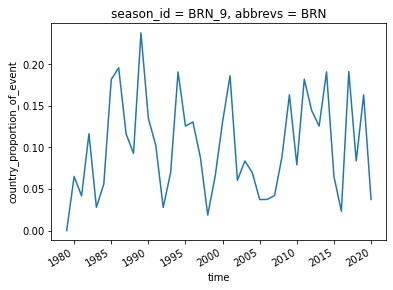

In [64]:
plot_dict_list[2]['da2'].country_proportion_of_event.sel(season_id='BRN_9').plot()

In [62]:
plot_dict_list[2]['da2'].country_proportion_of_event.mean('time').sel(season_id='BRN_9')

<xarray.DataArray 'country_proportion_of_event' ()>
array(0.10166741)
Coordinates:
    season_id  <U7 'BRN_9'
    abbrevs    <U4 'BRN'

In [63]:
plot_dict_list[2]['da2'].country_proportion_of_event.std('time').sel(season_id='BRN_9')

<xarray.DataArray 'country_proportion_of_event' ()>
array(0.05983945)
Coordinates:
    season_id  <U7 'BRN_9'
    abbrevs    <U4 'BRN'

In [69]:
xr.where(plot_dict_list[1]['da1'].country_proportion_of_event.sel(season_id='CO_1') > 0.06,
         1,
         0).sum()

<xarray.DataArray 'country_proportion_of_event' ()>
array(7)
Coordinates:
    season_id  <U7 'CO_1'
    abbrevs    <U4 'CO'

In [70]:
plot_dict_list[1]['da1'].country_proportion_of_event.sel(season_id='CO_1')

<xarray.DataArray 'country_proportion_of_event' (time: 42)>
array([0.05559533, 0.05559533, 0.09263056, 0.05559533, 0.05559533,
       0.11123029, 0.07414407, 0.05559533, 0.05559533, 0.09263056,
       0.07414407, 0.05559533, 0.05559533, 0.05559533, 0.05559533,
       0.05559533, 0.05559533, 0.05559533, 0.05559533, 0.05559533,
       0.07414407, 0.07414407, 0.05559533, 0.05559533, 0.05559533,
       0.05559533, 0.05559533, 0.05559533, 0.05559533, 0.05559533,
       0.05559533, 0.05559533, 0.05559533, 0.05559533, 0.05559533,
       0.05559533, 0.05559533, 0.05559533, 0.05559533, 0.05559533,
       0.05559533, 0.05559533])
Coordinates:
    season_id  <U7 'CO_1'
  * time       (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2020-01-01
    abbrevs    <U4 'CO'

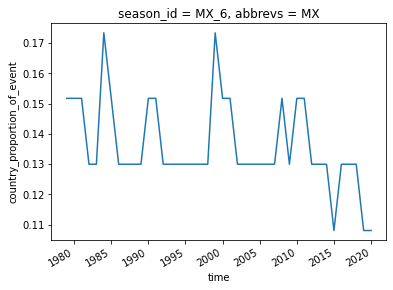

In [72]:
plot_dict_list[1]['da1'].country_proportion_of_event.sel(season_id='MX_6').plot()

In [73]:
plot_dict_list[1]['da1'].country_proportion_of_event.mean('time').sel(season_id='MX_6')

<xarray.DataArray 'country_proportion_of_event' ()>
array(0.13618434)
Coordinates:
    season_id  <U7 'MX_6'
    abbrevs    <U4 'MX'

In [74]:
plot_dict_list[1]['da1'].country_proportion_of_event.std('time').sel(season_id='MX_6')

<xarray.DataArray 'country_proportion_of_event' ()>
array(0.01449465)
Coordinates:
    season_id  <U7 'MX_6'
    abbrevs    <U4 'MX'

## Sign so that hot and dry events are distinct from wet and cold

In [ ]:
arabica_risks = {
                 'VPD > 0.82': vpd_growing_events.sel(time=slice('1980', '2020')).sel(season_id=arabica_season_ids),
                 'Tmax > 29.5': mx2t_growing_events.sel(time=slice('1980', '2020')).sel(season_id=arabica_season_ids),
                 'T < 18': t2m_lt_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=arabica_season_ids),
                 'T > 22': t2m_ut_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=arabica_season_ids),
                 'P < 1400': tp_lt_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=arabica_season_ids),
                 'P > 2000': tp_ut_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=arabica_season_ids)
                }

In [ ]:
robusta_risks = {
                 'Tmin fl < 15.8': mn2t_flowering_events.sel(time=slice('1980', '2020')).sel(season_id=robusta_season_ids),
                 'Tmin gr > 18.6': mn2t_growing_events.sel(time=slice('1980', '2020')).sel(season_id=robusta_season_ids),
                 'T < 22': t2m_lt_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=robusta_season_ids),
                 'T > 28': t2m_ut_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=robusta_season_ids),
                 'P < 2000': tp_lt_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=robusta_season_ids),
                 'P > 2500': tp_ut_growing_optimal_events.sel(time=slice('1980', '2020')).sel(season_id=robusta_season_ids)
                }

In [ ]:
signed_arabica_risks = copy.deepcopy(arabica_risks)
signed_arabica_risks['T < 18'] *= -1
signed_arabica_risks['P > 2000'] *= -1

In [ ]:
signed_robusta_risks = copy.deepcopy(robusta_risks)
signed_robusta_risks['Tmin fl < 15.8'] *= -1
signed_robusta_risks['T < 22'] *= -1
signed_robusta_risks['P > 2500'] *= -1

In [ ]:
year_counts = fn.plot_n_signed_events([arabica_risks, robusta_risks],
                                        [signed_arabica_risks, signed_robusta_risks],
                                        y_order=country_order,
                                        save_fig=True, filename='signed_events.pdf')

# Trend (Mann-Kendall) test the number of warm/dry and cold/wet hazards per year

In [ ]:
def mk_theil_sen_1d(X):
    """
    Performs the Mann-Kendall trend test and calculates the Theil-Sen slope
    """
    
    from scipy.stats import theilslopes
    
    X = X[~np.isnan(X)]
    n = X.shape[-1] # length of X (usually time)
    stack = np.full((n - 1, n), np.nan)
    
    np.fill_diagonal(stack[:,1:], X[0]) # fill the above-diagonal with first element of X
    for i in range(n-1): # fill diagonal and below-diagonals with remaining elements
        np.fill_diagonal(stack[i:,:], X[i+1])
    
    diff = np.expand_dims(stack[:,0], -1) - stack[:,1:] # difference between each element and all previous elements of X
    sign = np.sign(diff) # sign of these differences
    S = sign[~np.isnan(sign)].astype(int).sum() # sum of signed differences
    
    ts_slope, ts_intercept = theilslopes(X)[:2] # First element is estimate of slope, second is intercept
    
    return (S, ts_slope, ts_intercept)

In [ ]:
def apply_mk(X):
    """
    Wrapper for mk_theil_sen_1d to only return test statistic, in a DataArray
    """
    S = mk_theil_sen_1d(X)[0]
    return xr.DataArray(S)

In [ ]:
def bootstrap_mk(da, n_repeats):
    """
    Bootstrap da and apply Mann Kendall trend test
    """
    L = fn.estimate_L(da).astype('int').values
    print(L)
    bootstraps = block_bootstrap(wd_risks, blocks={'time': L}, n_iteration=n_repeats, exclude_dims=None, circular=True)

    resamples = xr.apply_ufunc(apply_mk, bootstraps, input_core_dims=[['time']], output_core_dims=[[]],
                                dask='forbidden', vectorize=True)
    return resamples

In [ ]:
def get_pvalue(q):
    """
    Get the p value from the quantile q
    """
    return 1 - q if q > 0.5 else q

### Test on warm and dry events only

In [ ]:
wd_risks = xr.concat([arabica_risks['VPD > 0.82'],
                      arabica_risks['Tmax > 29.5'],
                      arabica_risks['T > 22'],
                      arabica_risks['P < 1400'],
                      robusta_risks['Tmin gr > 18.6'],
                      robusta_risks['T > 28'],
                      robusta_risks['P < 2000']],
                     dim='season_id')
wd_risks = wd_risks['event'].sum('season_id')

In [ ]:
wd_mk = mk_theil_sen_1d(wd_risks)[0]
wd_mk

In [ ]:
wd_resamples = bootstrap_mk(wd_risks, n_repeats=10000)

In [ ]:
wd_q = fn.get_quantile(wd_mk, wd_resamples)
wd_pval = get_pvalue(wd_q)
wd_pval

In [ ]:
cw_risks = xr.concat([arabica_risks['T < 18'],
                      arabica_risks['P > 2000'],
                      robusta_risks['Tmin fl < 15.8'],
                      robusta_risks['T < 22'],
                      robusta_risks['P > 2500']],
                     dim='season_id')
cw_risks = cw_risks['event'].sum('season_id')

In [ ]:
cw_mk = mk_theil_sen_1d(cw_risks)[0]

In [ ]:
cw_resamples = bootstrap_mk(cw_risks, n_repeats=10000)

In [ ]:
cw_q = fn.get_quantile(cw_mk, cw_resamples)
cw_pval = get_pvalue(cw_q)
cw_pval

# Close cluster

In [ ]:
client.close()
cluster.close()